# Cryptocurrency Time Series Forecasting using ARIMA

# Import Libraries

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
btc = pd.read_csv('../data/Bitcoin/BTC-USD-NEW.csv', parse_dates = ['date'], index_col = 'date', date_parser = dateparse)
btc = btc[btc.columns[1:]]
btc.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2015-09-13,235.242004,235.934998,229.332001,230.511993,230.511993,18478800.0
2015-09-14,230.608994,232.440002,227.960999,230.643997,230.643997,20997800.0
2015-09-15,230.492004,259.182007,229.822006,230.304001,230.304001,19177800.0
2015-09-16,230.250000,231.214996,227.401993,229.091003,229.091003,20144200.0
2015-09-17,229.076004,230.285004,228.925995,229.809998,229.809998,18935400.0


In [3]:
btc.tail()

,open,high,low,close,adj_close,volume
date,,,,,,
2021-09-09,45774.742188,47261.949219,45669.738281,46391.421875,46391.421875,3.867266e+10
2021-09-10,46396.664063,47031.742188,44344.484375,44883.910156,44883.910156,3.915467e+10
2021-09-11,44869.839844,45969.292969,44818.265625,45201.457031,45201.457031,3.449984e+10
2021-09-12,45206.628906,46364.878906,44790.460938,46063.269531,46063.269531,2.788198e+10
2021-09-13,46114.171875,46234.527344,44268.375000,44743.929688,44743.929688,3.184200e+10


# Monthly Forecasting

In [4]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

### Stationarity check and Seasonal decomposition

If a time series is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting

Dickey_Fuller test: p=0.922666


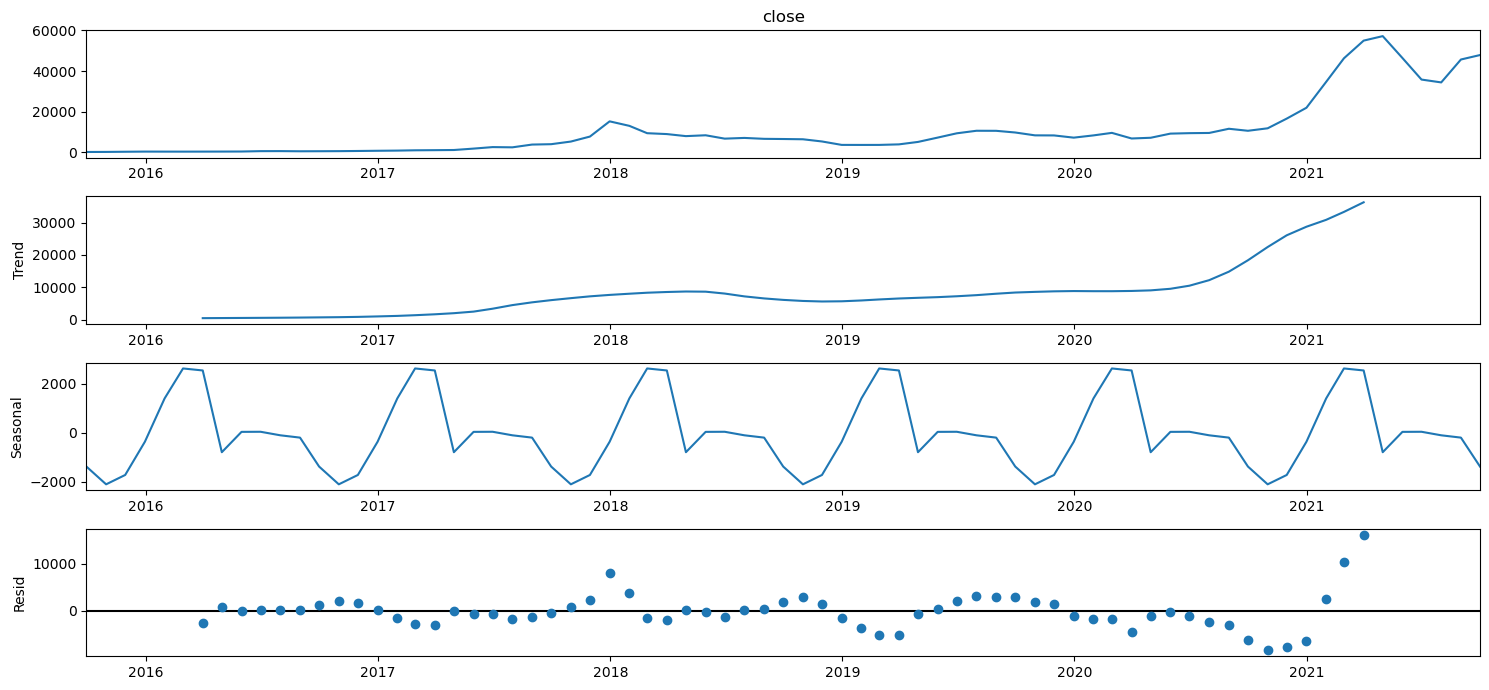

In [5]:
# seasonal_decompose(btc_month.close, freq = 12).plot()
seasonal_decompose(btc_month.close).plot()
print('Dickey_Fuller test: p=%f' % adfuller(btc_month.close)[1])
plt.show()

The p-value indicates that series is not stationary with 99.88% confidence

### Box-Cox Transformation

Let's use the Box-Cox transformation to suppress some of the variance

The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it the parameter needs to be estimated from the data. In time series the process could have a non-constant variance. If the variance changes with time the process is nonstationary. It is often desirable to transform a time series to make it stationary. Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to remove polynomial trends or seasonal trends respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p and q for the ARMA model, the AR and MA parameters can then be estimated

In [6]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.close)
print('Dickey_Fuller test: p=%f' % adfuller(btc_month.close_box)[1])

Dickey_Fuller test: p=0.772409


The p-value states that series is still not stationary

### Differencing

When building models to forecast time series data (like ARIMA), another pre-processing step is differencing the data (calculating sequentially xt-xt-1) until we get to a point where the series is stationary. Models account for oscillations but not for trends, and therefore, accounting for trends by differencing allows us to use the models that account for oscillations.

Once the model has been constructed, we can account for trends separaly, by adding the trends component-wise


### Seasonal differentiation

One method of differencing data is seasonal differencing, which involves computing the difference between an observation and the corresponding observation in the previous year.

In [7]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print('Dickey-Fuller test: p=%f' % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey-Fuller test: p=0.283287


The p-value indicates that series is still not stationary

In [8]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print('Dickey-Fuller test: p=%f' % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey-Fuller test: p=0.025693


The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05

##### Regular differentiation

Sometimes it may be necessary to difference the data a second time to obtain a stationary time series, which is referred to as second order differencing

Dickey-Fuller test: p=0.000054


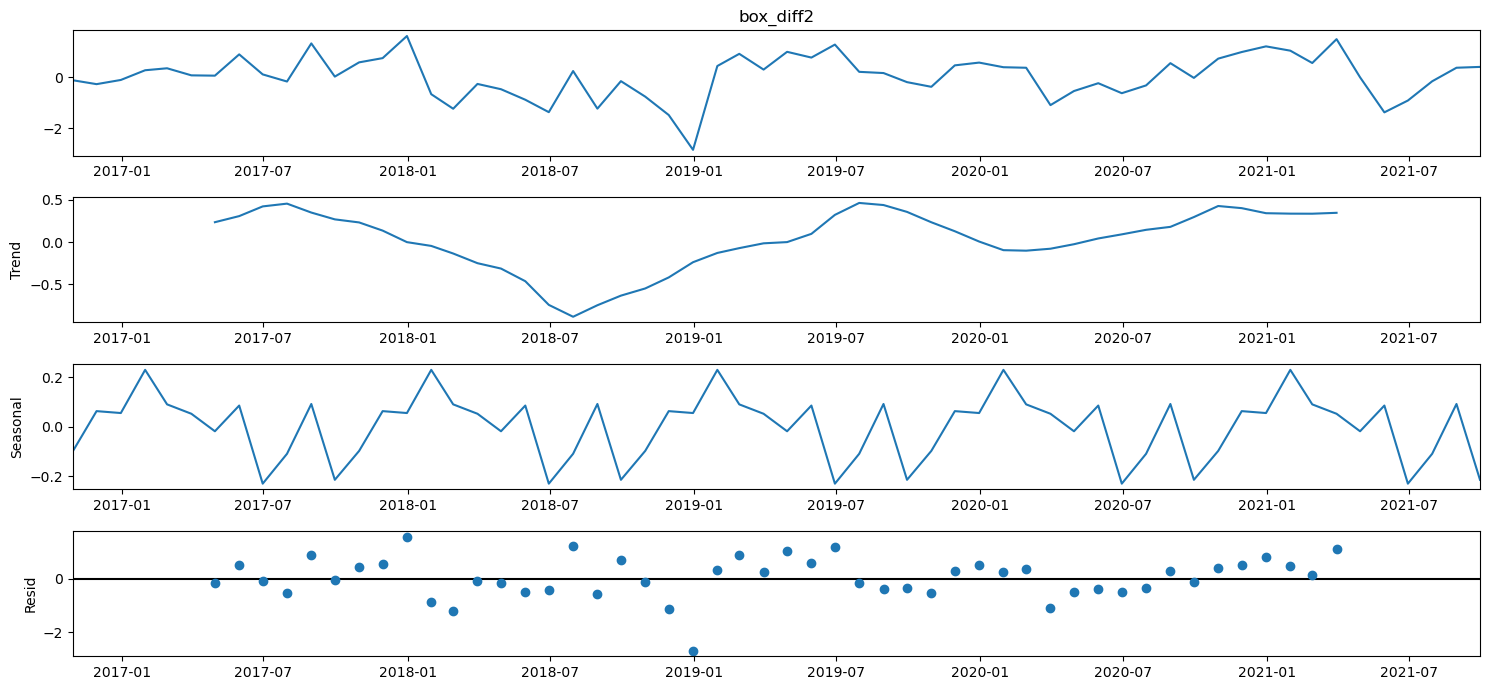

In [9]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()
print('Dickey-Fuller test: p=%f' % adfuller(btc_month.box_diff2[13:])[1])

plt.show()

The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05

##### Autocorrelation

Autocorrelation is the correlation of a time series with the same time series lagged. It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the datasets.

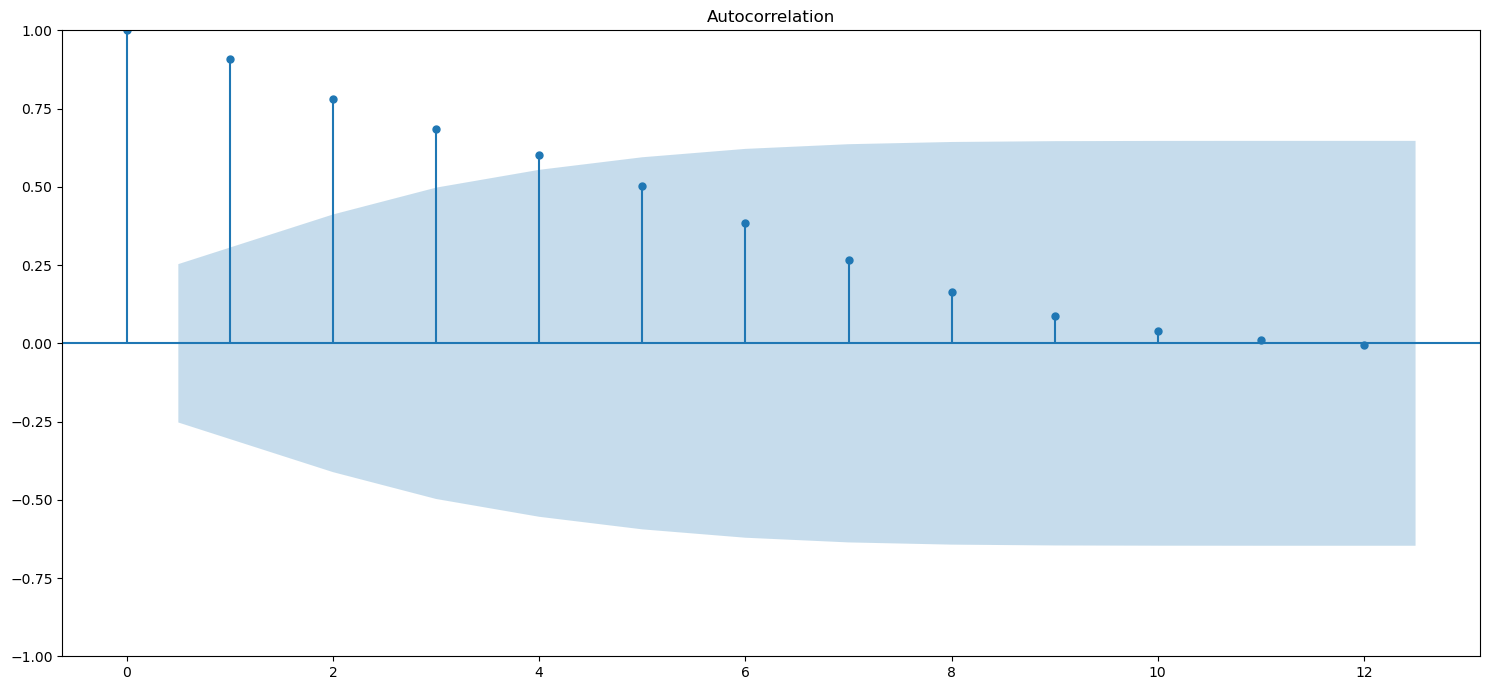

In [10]:
# autocorrelation_plot(btc_month.close)
plot_acf(btc_month.close[13:].values.squeeze(), lags = 12)

plt.tight_layout()
plt.show()

There is a positive correlation with the first 10 lags that is perhaps significant for the first 2-3 lags.

A good starting point for that AR parameter of the model may be 3

Let's try out autocorrelation on the differences

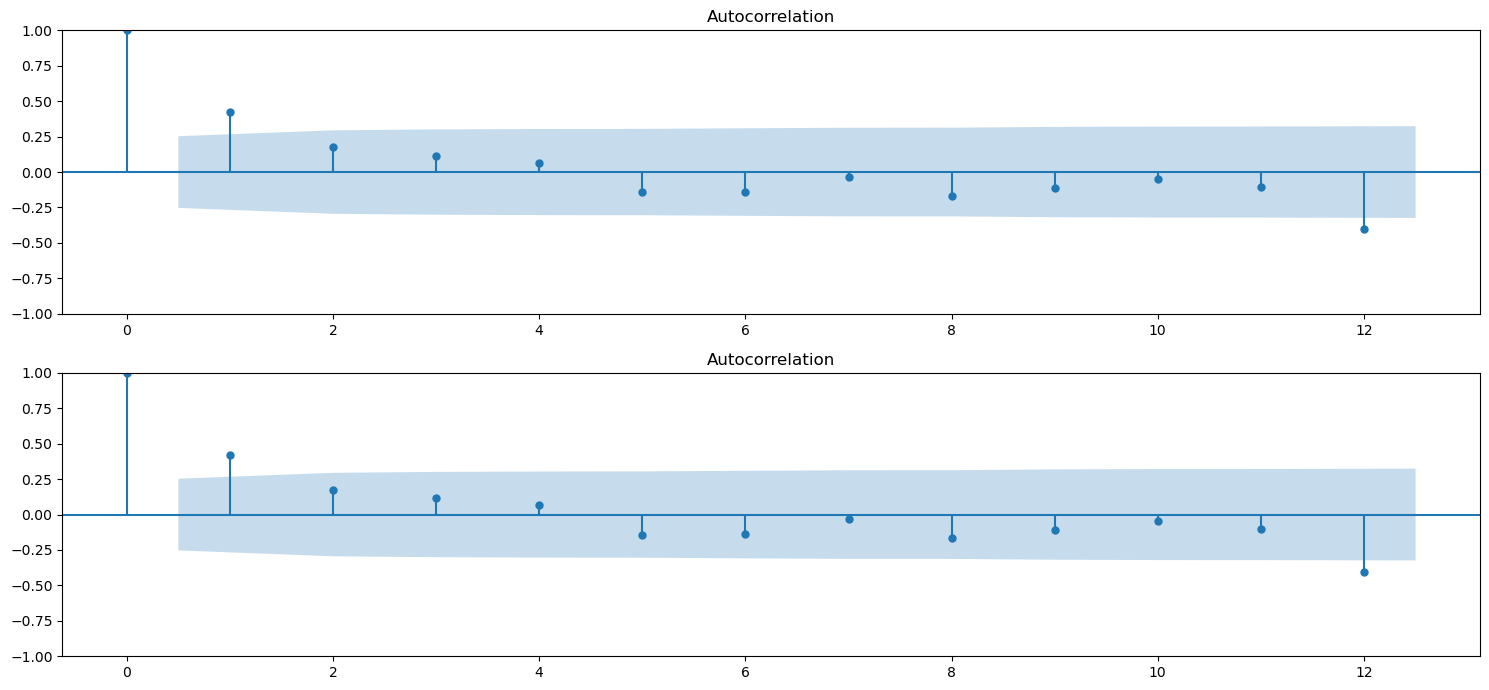

In [11]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation fuction
# sm.graphics.tsa.plot.acf(btc_month.box_diff2[13:].values.squeeze(), lags = 48, ax = ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags = 12, ax = ax)
ax = plt.subplot(212)
# sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags = 48, ax = ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags = 12, ax = ax)
plt.tight_layout()
plt.show()

There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models

There may be a seasonal component available in the residuals at the lags of quarters (3 months) represented by spikes at these intervals. But probably not significant

# ARIMA Model

AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets

p - the number of lag observations to include in the model, or lag order (AR)

d - the number of times that the raw observations are differenced, or the degree of differencing  (I)

q - the size of the moving average window, also called the order of moving average (MA) 

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression affect the regression model. A value of 0 for a parameter indicates to not use that element of the model

##### Parameter Selection

We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with SARIMAX() and assess its overall quality.

We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits that data very well while using lots of features will be assigned a large AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [12]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order = (param[0], d, param[1])).fit(disp = -1)
    except ValueError:
        print('bad parameter combination: ', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Note that some parameter combinations may lead to numerical misspeccifications and we explicitly disabled warning messages in order to avoid an overload of warning messages. These misspecifications can also lead to errors and throw an exception, so we catch these exceptions and just print out the parameter combination that cause these issues

In [13]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending = True).head())

  parameters         aic
3     (1, 0)  112.414097
1     (0, 1)  113.534806
7     (2, 1)  114.229081
4     (1, 1)  114.336861
6     (2, 0)  114.364426


Usually, AIC is positive; however it can be shifted by any additive constant, and some shifts can result in negative values of AIC. It is not the absolute size of the AIC value, it is the relative values over the set of models considered, and particularly the differences AIC values, that are important.

In [14]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   73
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -54.207
Date:                Tue, 14 Mar 2023   AIC                            112.414
Time:                        08:21:03   BIC                            116.967
Sample:                    09-30-2015   HQIC                           114.227
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4368      0.077      5.696      0.000       0.286       0.587
sigma2         0.2631      0.041      6.494      0.000       0.184       0.343
Ljung-Box (L1) (Q):                   0.06   Jarque-

##### Analysis of Results

The coef column shows the weight of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

In [15]:
print('Dickey-Fuller test: p=%f' % adfuller(best_model.resid[13:])[1])

Dickey-Fuller test: p=0.000000


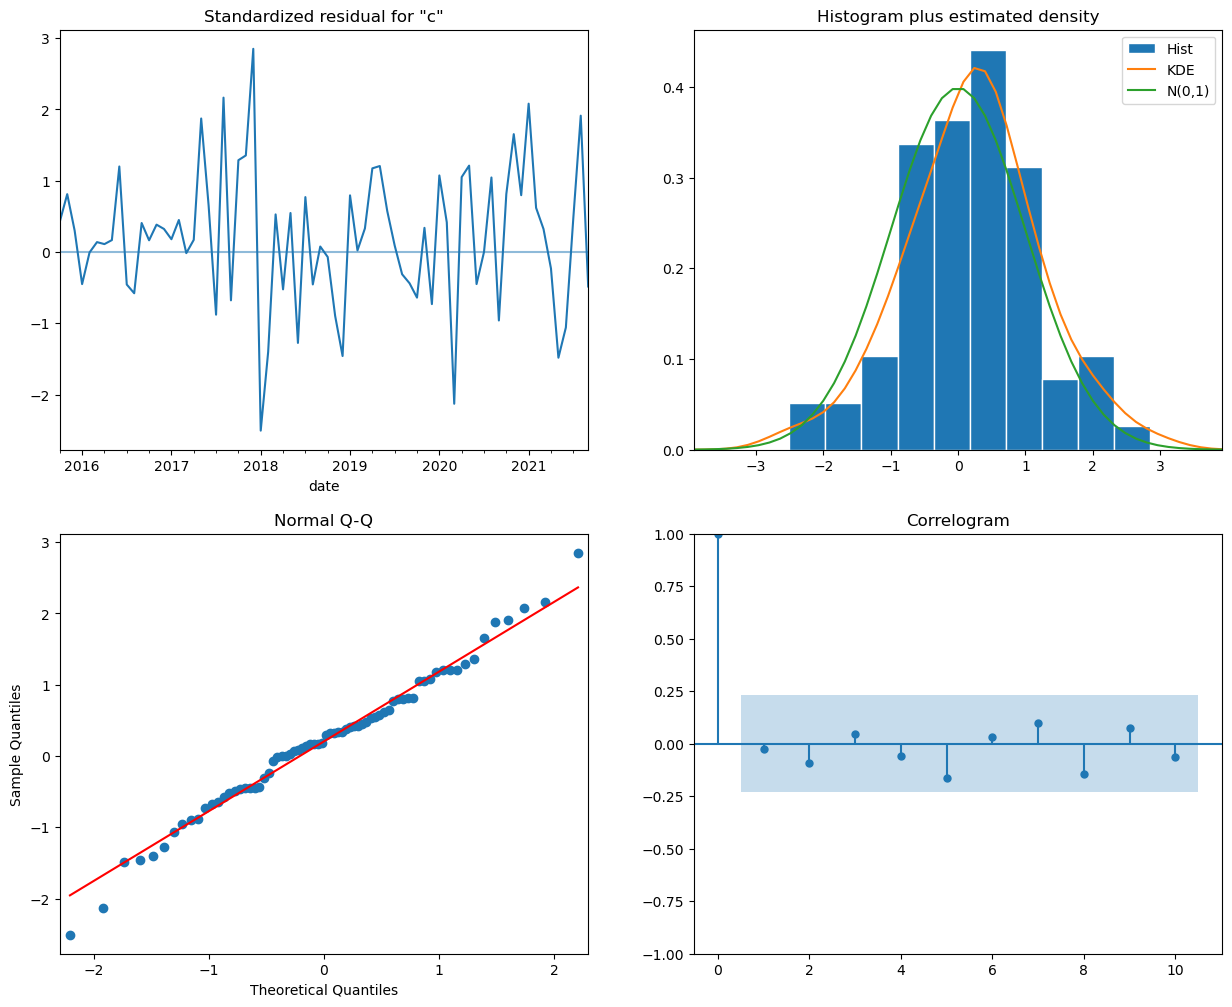

In [16]:
best_model.plot_diagnostics(figsize = (15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our models are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In the histogram (top right), the KDE line should follow the N(0, 1) line (normal distribution with mean 0, standard deviation 1) closely. This is an indication whether the residuals are normally distributed or not.

In the Q-Q-plot the ordered distributio nof residuals (blue dots) should follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is an indication whether the residuals are normally distributed.

The standardized residual plot doesn't display any obvious seasonality. This is confirmed by the autocorrelation plot, which shows that the time series residuals have low correlation with lagged version of itself

Conclusion: We may consider trying to standardize the distribution further. But let's go ahead and do a prediction anyway.

### Prediction

In [17]:
# Inverse Box-Cox Transformation Function
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

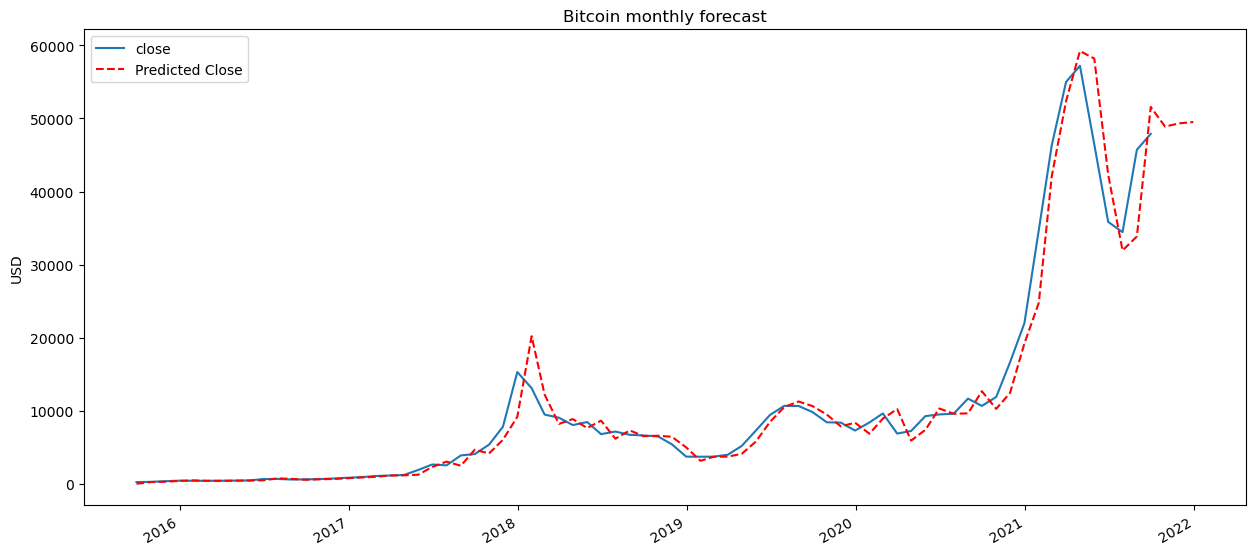

In [18]:
# Prediction
btc_month_pred = btc_month[['close']]
# date_list - [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31), datetime(2018, 11, 30), datetime(2018, 12, 31)]
date_list = [datetime(2021, 9, 30), datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31)]
future = pd.DataFrame(index = date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

# btc_month_pred['forecast'] = invboxcox(best_model.predict(start = 0, end = 75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start = datetime(2015, 9, 30), end = datetime(2021, 12, 31)), lmbda)

plt.figure(figsize = (15, 7))
btc_month_pred.close.plot()
btc_month_pred.forecast.plot(color = 'r', ls = '--', label = 'Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()



# SARIMAX Model

Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

Apparently bitcoin data does display slight seasonality. So let's try to improve the model by using SARIMA

When dealing with seasonal effects, we make use of seasonal ARIMA, which is denoted as ARIMA(p, d, q)(P, D, Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while(P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The terms is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.)

In [19]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D = 1
d = 1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        # model = SARIMAX(btc_month.close_box, order = (param[0], d, param[1]), seasonal_order = (param[2], D, param[3], 12)).fit(disp = -1)
        model = SARIMAX(btc_month.close_box, order = (param[0], d, param[1]), seasonal_order = (param[2], D, param[3], 4)).fit(disp = -1)
    except ValueError:
        print('bad parameter combination: ', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [20]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending = True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  119.351389
7   (0, 1, 0, 1)  119.411291
25  (1, 1, 0, 1)  121.057760
37  (2, 0, 0, 1)  121.136424
13  (0, 2, 0, 1)  121.137818
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   73
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                 -56.676
Date:                             Tue, 14 Mar 2023   AIC                            119.351
Time:                                     08:21:23   BIC                            126.010
Sample:                                 09-30-2015   HQIC                           121.990
                                      - 09-30-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

##### Analysis of Results

In [21]:
print('Dickey-Fuller test: p=%f' % adfuller(best_model.resid[13:])[1])

Dickey-Fuller test: p=0.000000


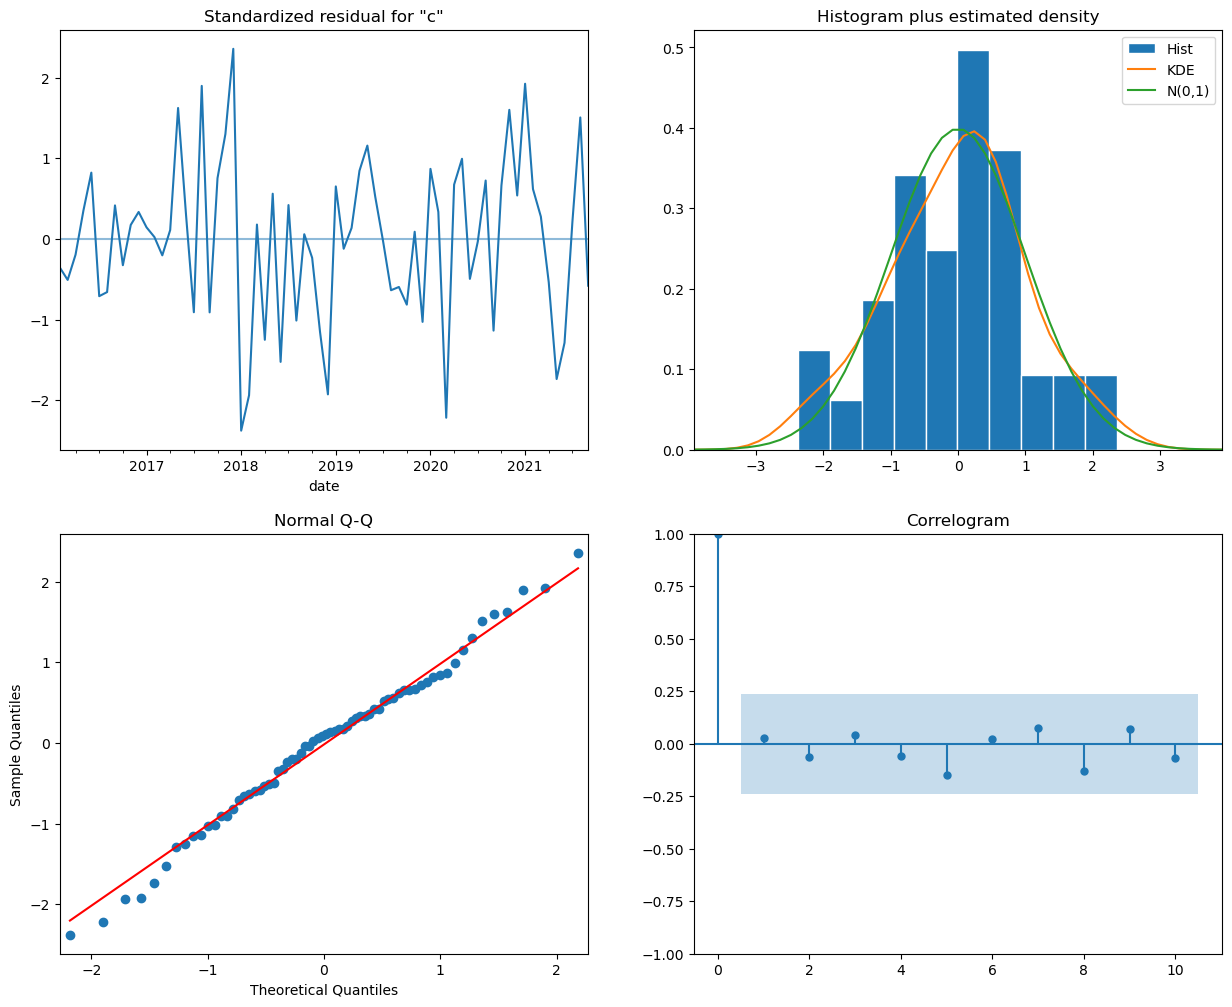

In [22]:
best_model.plot_diagnostics(figsize = (15, 12))
plt.show()

Dickey-Fuller test: p=0.000000


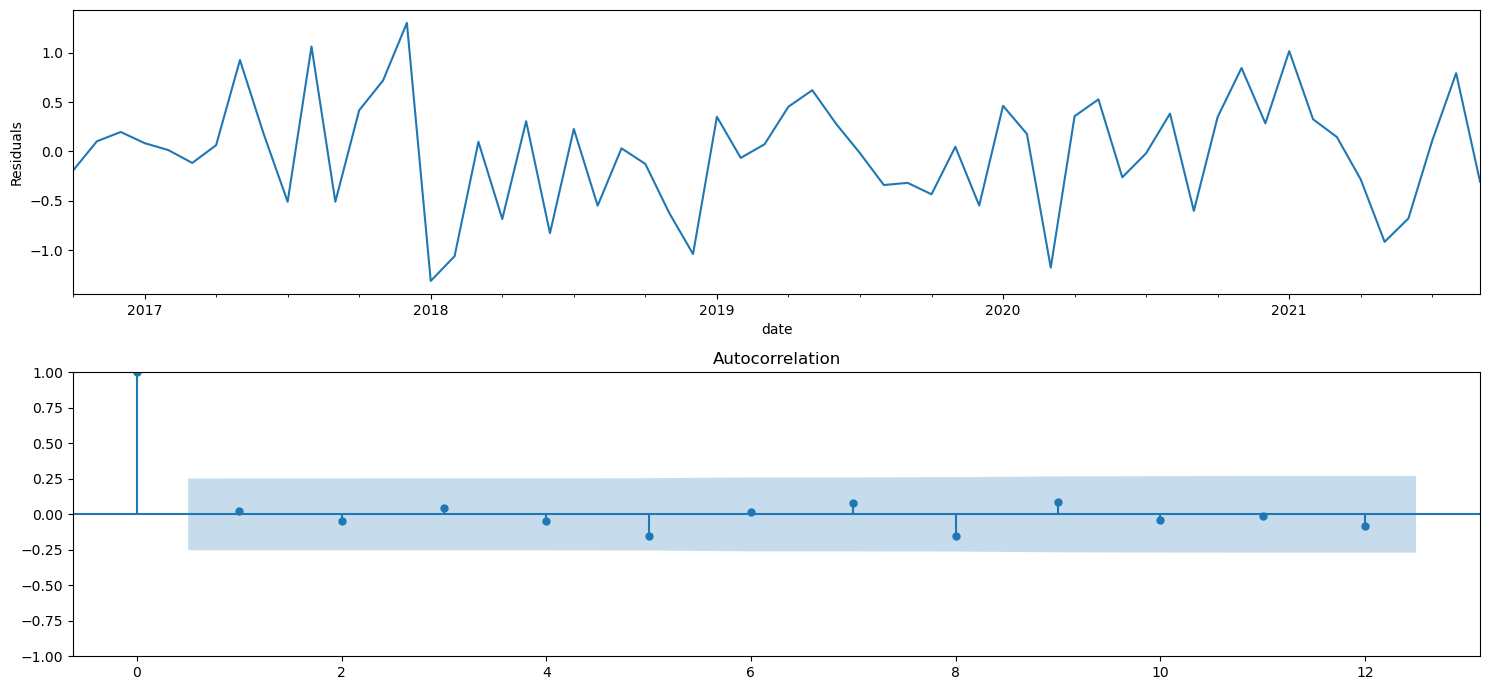

In [23]:
# STL_decomposition
plt.figure(figsize = (15, 7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
# sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags = 48, ax = ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags = 12, ax = ax)

print('Dickey-Fuller test: p=%f' % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

### Prediction

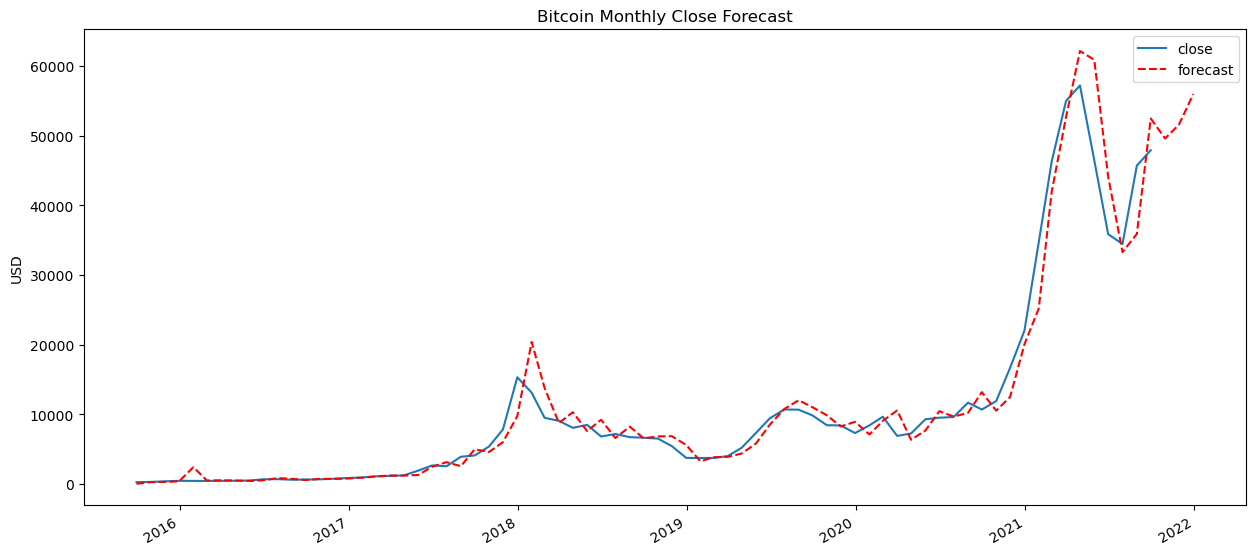

In [24]:
# Prediction
btc_month2 = btc_month[['close']]
date_list = [datetime(2021, 9, 30), datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31)]
future = pd.DataFrame(index = date_list, columns = btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start = 0, end = 75), lmbda)

plt.figure(figsize = (15, 7))
btc_month2.close.plot()
btc_month2.forecast.plot(color = 'r', ls = '--', label = 'forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

### Validation

A simple indicator of how accurate out forecast is is the root mean square error (RMSE). So let's calculate RMSE for the one-step predictions starting from 2018, through to the end of 2020

In [25]:
y_forecasted = btc_month2.forecast
y_truth = btc_month2['2018-01-01' : '2020-01-01'].close

# Compute the root mean squared error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Root Mean Squared Error: {}'.format(round(rmse, 2)))

Root Mean Squared Error: 2073.76


A better representation of longer-term predictive power can be obtained using dynamic forecasts In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points

In the code chunk below, we specify to start computing the dunamic forecasts and confidence intervals from mid 2020 onwards

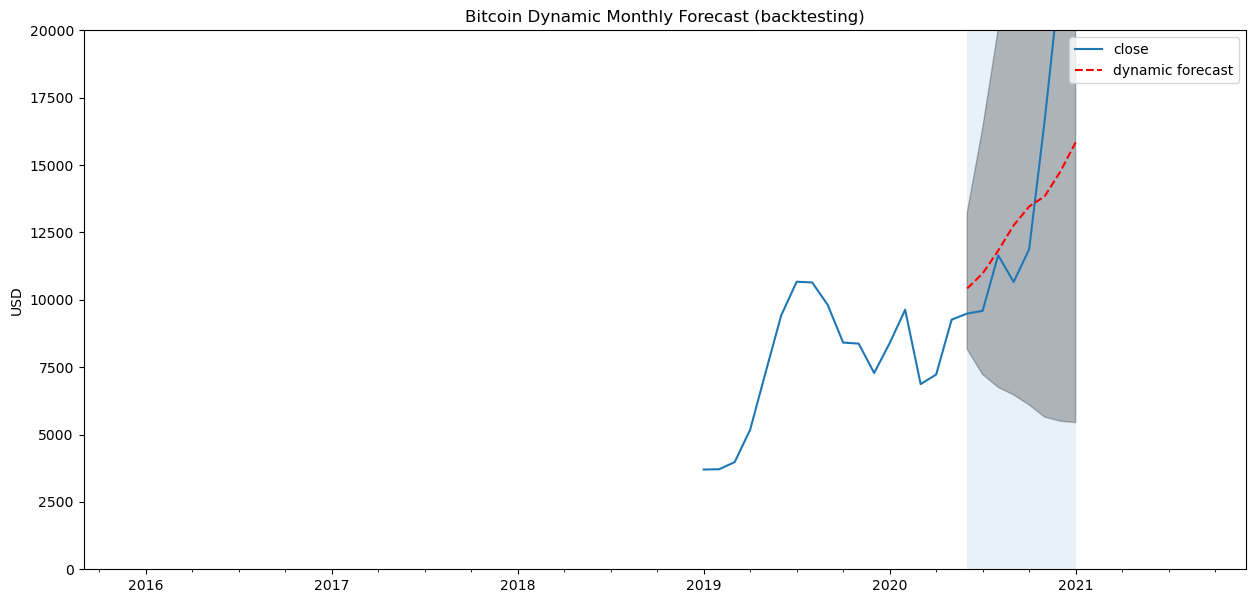

In [26]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2020-06-30')
t2 = pd.to_datetime('2021-01-31')
btc_month_dynamic = best_model.get_prediction(start = t1, end = t2, dynamic = True, full_results = True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualize
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha = 0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.figure(figsize = (15, 7))
plt.ylim((0, 20000))

btc_month2.close['2019':'2021-01'].plot(label = 'close')
btc_month2.dynamic_forecast.plot(color = 'r', ls = '--', label = 'dynamic forecast')

plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = .25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha = .1, zorder = -1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()

This is pretty bad but not surprising given how the prices started going insane around late 2020. Let's see how well the model does in a different time period when things were a little more normal

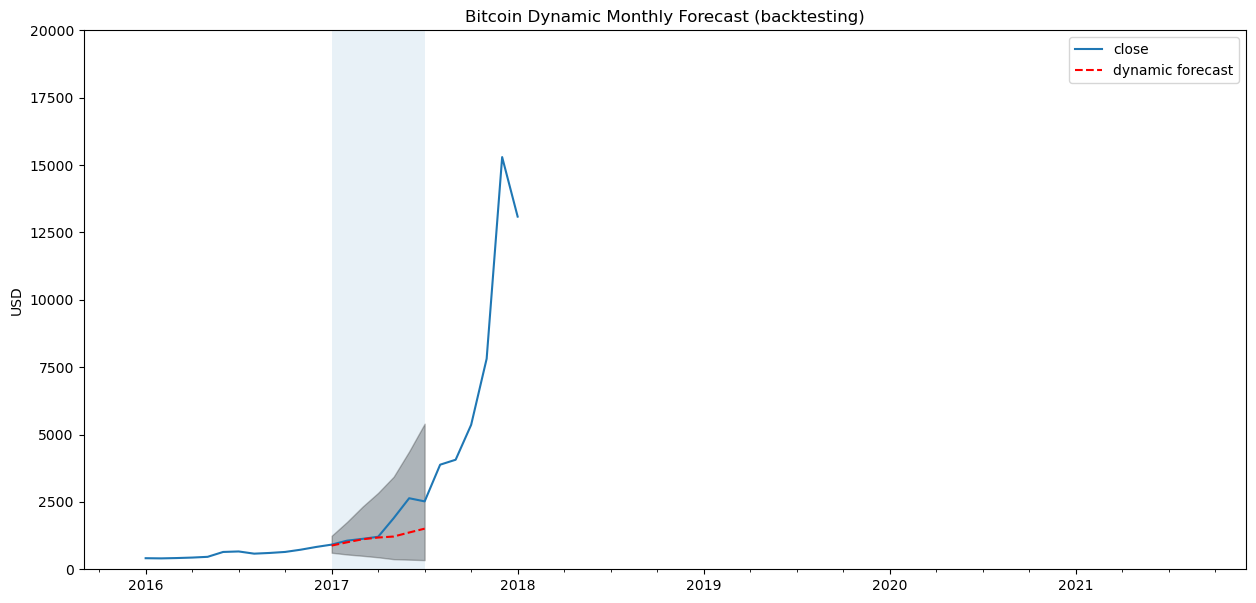

In [27]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-01-31')
t2 = pd.to_datetime('2017-07-31')
btc_month_dynamic = best_model.get_prediction(start = t1, end = t2, dynamic = True, full_results = True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualize
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha = 0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.figure(figsize = (15, 7))
plt.ylim((0, 20000))

btc_month2.close['2016':'2018-01'].plot(label = 'close')
btc_month2.dynamic_forecast.plot(color = 'r', ls = '--', label = 'dynamic forecast')

plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = .25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha = .1, zorder = -1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()

The results indicate that the model is still a little rough and not something we should use as trading advice, but that was not unexprected due to the extremely volatile nature of cryptocurrencies, especially in the last 1 year.

It is probably also not such a good idea to try and predict 6 months into the future as we can see how insane even the 80% confidence interval becomes out this far. Maybe sticking to 1 month advance predictions is more sensible. Or maybe even predicting on a daily basis.

There are a number of things we could do to potentially improve the model
- Use a different technique to standardize the distribution
- Use different differentiation techniques
- Discard the time period before ctyptocurrencies started taking off
- Try modelling per day instead of month, with a smaller forecast window
- Use other models or machine learning instead of ARIMA